# 案例：股票价格预测


金融领域面临的最大挑战之一就是预测股票价格。然而，随着近期机器学习应用的飞速发展，该领域正在演变为利用非确定性解决方案进行学习，以做出更准确的预测。机器学习技术天然适用于基于历史数据进行股票价格预测。预测可以针对单个未来时间点或一系列未来时间点进行。

作为概述，除了股票本身的历史价格之外，通常用于股票价格预测的特征如下：

- 相关资产
一个组织依赖并与许多外部因素互动，包括其竞争对手、客户、全球经济、地缘政治局势、财政和货币政策、获得资本等。因此，其股价可能不仅与其他公司的股价相关，还可能与其他资产相关，例如商品、外汇、广泛指数甚至固定收益证券。

- 技术指标
许多投资者遵循技术指标。移动平均线、指数移动平均线和动量是最流行的指标。

- 基本面分析
用于收集可用于基本面分析的特征的两个主要数据源包括：

- 业绩报告
公司年度和季度报告可以用来提取或确定关键指标，例如 ROE（股本回报率）和 P/E（市盈率）。

- 新闻
新闻可以预示可能导致股价朝特定方向移动的即将发生的事件。


本案例研究将利用各种基于监督学习的模型，结合微软公司的相关资产及其自身历史数据，来预测其股票价格。通过本案例研究，将熟悉股票预测建模的一般机器学习方法，涵盖从数据收集和清理，到构建和调整不同模型的整个过程。

本案例研究将重点关注以下方面：

- 探索用于预测股票收益的各种机器学习和时间序列模型，涵盖不同复杂程度的模型。
- 使用多种图表（例如密度图、相关图、散点图等）进行数据可视化。
- 利用深度学习 (LSTM) 模型进行时间序列预测。
- 实施时间序列模型（例如 ARIMA 模型）的网格搜索。
- 解释结果，并检查模型对数据的过拟合和欠拟合问题。

## 1. 问题定义

本案例研究采用监督回归框架，将微软股票的周收益率作为预测变量。我们需要了解影响微软股价的因素，并将尽可能多的信息纳入模型中。在之前章节讨论过的相关资产、技术指标和基本面分析中，本案例研究将重点关注相关资产作为特征。

本案例研究使用的自变量（除微软历史数据以外）为以下可能相关的资产：

股票：IBM (IBM)股票 和 Alphabet (GOOGL)股票

汇率：USD/JPY（美元兑日元） 和 GBP/USD（英镑兑美元）汇率

指数：S&P 500指数、道琼斯指数和 VIX指数

本案例研究使用的数据集来自Wind数据库。除了准确预测股价之外，本案例研究还将展示基于时间序列和监督回归的股票价格预测建模的每个步骤的基础设施和框架。我们将使用 2010 年至今的每日收盘价。



## 2. 载入数据集

首先我们使用pandas读取CSV文件的方法，把从Wind终端下载的数据加载到内存中，并指定第0列为行索引。

In [1]:
import pandas as pd
data = pd.read_csv('datasets/case01.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,MSFT.O,IBM.N,GOOGL.O,SPX.GI,VIX.GI,DJI.GI,USDJPY.FX,GBPUSD.FX
DateTime,,,,,,,,
2010-01-04,23.610089,76.698443,15.683935,1132.99,20.04,10583.96,92.52,1.6089
2010-01-05,23.617718,75.771924,15.614868,1136.52,19.35,10572.02,91.68,1.5991
2010-01-06,23.472777,75.279710,15.221237,1137.14,19.16,10573.68,92.32,1.6015
2010-01-07,23.230192,75.019127,14.866894,1141.69,19.06,10606.86,93.31,1.5933
2010-01-08,23.388864,75.771924,15.065086,1144.98,18.13,10618.19,92.66,1.6019


为了让列名变得简洁，我们可以使用以下方法：

In [2]:
tickers={'MSFT.O':'MSFT','IBM.N':'IBM','GOOGL.O':'GOOGL','SPX.GI':'SPX',
         'VIX.GI':'VIX','DJI.GI':'DJI','USDJPY.FX':'USDJPY','GBPUSD.FX':'GBPUSD'}
data.columns = [tickers[i] for i in data.columns]
data.head()

,MSFT,IBM,GOOGL,SPX,VIX,DJI,USDJPY,GBPUSD
DateTime,,,,,,,,
2010-01-04,23.610089,76.698443,15.683935,1132.99,20.04,10583.96,92.52,1.6089
2010-01-05,23.617718,75.771924,15.614868,1136.52,19.35,10572.02,91.68,1.5991
2010-01-06,23.472777,75.279710,15.221237,1137.14,19.16,10573.68,92.32,1.6015
2010-01-07,23.230192,75.019127,14.866894,1141.69,19.06,10606.86,93.31,1.5933
2010-01-08,23.388864,75.771924,15.065086,1144.98,18.13,10618.19,92.66,1.6019


在本文中，我们定义了因变量（Y）和自变量（X）。所预测的变量为微软（MSFT）的每周回报。我们假设一周内的交易日数为五天，使用五个交易日来计算回报。对于自变量，我们使用相关资产和微软（MSFT）的历史回报，以不同频率进行计算。

作为自变量使用的变量包括股票（IBM 和 GOOG）、货币（USD/JPY 和 GBP/USD）以及指数（标普500、道琼斯和VIX）的滞后五日回报，以及微软（MSFT）的滞后5日、15日、30日和60日回报。滞后五日变量采用时间延迟方法，将时间序列组件嵌入其中，其中滞后变量被包含为自变量之一。这一步骤将时间序列数据重新构建为基于监督回归的模型框架。

In [3]:
import numpy as np
return_period = 5
Y = np.log(data.loc[:, 'MSFT']).diff(return_period).shift(-return_period)
Y.name = Y.name+'_pred'
Y

DateTime
2010-01-04   -0.022216
2010-01-05   -0.029168
2010-01-06   -0.013744
2010-01-07    0.016544
2010-01-08    0.006502
                ...   
2024-03-04         NaN
2024-03-05         NaN
2024-03-06         NaN
2024-03-07         NaN
2024-03-08         NaN
Name: MSFT_pred, Length: 3444, dtype: float64

In [4]:
X1 = np.log(data.loc[:, ['GOOGL', 'IBM']]).diff(return_period)
X2 = np.log(data.loc[:, ['USDJPY', 'GBPUSD']]).diff(return_period)
X3 = np.log(data.loc[:, ['SPX', 'VIX','DJI']]).diff(return_period)

In [5]:
return_period = 5
X4 = pd.concat([np.log(data.loc[:, 'MSFT']).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_5DT', 'MSFT_15DT', 'MSFT_30DT', 'MSFT_60DT']

In [6]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [7]:
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [8]:
#pd.set_option('display.precision', 5)
dataset.head()

,MSFT_pred,GOOGL,IBM,USDJPY,GBPUSD,SPX,VIX,DJI,MSFT_5DT,MSFT_15DT,MSFT_30DT,MSFT_60DT
DateTime,,,,,,,,,,,,
2010-04-06,0.037816,0.010206,0.002641,0.013097,0.018784,0.013731,-0.080469,0.006780,-0.009167,0.001024,0.020328,-0.049438
2010-04-13,0.029447,0.032124,0.000775,-0.005991,0.007637,0.006586,-0.001850,0.004496,0.037816,0.028312,0.048101,0.010594
2010-04-20,-0.016559,-0.055593,0.005102,0.000000,0.000065,0.008210,-0.029442,0.008822,0.029447,0.058097,0.091078,0.020738
2010-04-27,-0.032790,-0.047938,-0.006731,-0.001181,-0.008751,-0.019625,0.371629,-0.011314,-0.016559,0.050705,0.051729,0.055370
2010-05-05,-0.013831,-0.037162,-0.010613,0.009302,-0.009490,-0.015160,0.088070,-0.011333,-0.032790,-0.019901,0.008410,0.054109


变量 MSFT_pred 是微软股票的回报，也是预测变量。数据集包含了其他相关股票、货币和指数的滞后系列。此外，它还包括微软历史回报的滞后数据。


## 3. 探索性数据分析

本节将涵盖描述性统计、数据可视化以及时间序列分析。

<a id='3.1'></a>
### 3.1. 描述性统计

我们观察下数据集

In [9]:
dataset.describe()

,MSFT_pred,GOOGL,IBM,USDJPY,GBPUSD,SPX,VIX,DJI,MSFT_5DT,MSFT_15DT,MSFT_30DT,MSFT_60DT
count,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000,676.000000
mean,0.004269,0.003386,0.001339,0.000720,-0.000246,0.002167,-0.000399,0.001885,0.004273,0.012807,0.025636,0.050550
std,0.034867,0.037085,0.030678,0.013256,0.013746,0.023548,0.153191,0.022989,0.034865,0.054341,0.072687,0.097057
min,-0.178707,-0.167899,-0.231184,-0.044678,-0.121548,-0.198044,-0.465348,-0.208720,-0.178707,-0.282310,-0.249381,-0.226603
25%,-0.014746,-0.015803,-0.013260,-0.006075,-0.008135,-0.007049,-0.083064,-0.007599,-0.014746,-0.019417,-0.019207,-0.011743
50%,0.006966,0.004478,0.002308,0.000989,0.000392,0.004315,-0.009936,0.002783,0.006966,0.015713,0.030722,0.056612
75%,0.024792,0.024222,0.018489,0.008327,0.007796,0.013767,0.066578,0.013758,0.024792,0.047258,0.071850,0.115235
max,0.140028,0.174206,0.117849,0.068420,0.060804,0.098984,0.960131,0.115749,0.140028,0.172386,0.246155,0.350267


<a id='3.2'></a>
### 3.2. 数据可视化

了解数据的最快方法是通过可视化。可视化包括独立理解数据集的每个属性。我们将查看散点图和相关系数矩阵。这些图形让我们感受到数据之间的相互依赖关系。通过创建相关系数矩阵，可以计算并显示每对变量之间的相关性。因此，除了独立变量和因变量之间的关系，它还显示了独立变量之间的相关性。这是有用的，因为在数据中存在高度相关的输入变量时，一些机器学习算法如线性回归和逻辑回归可能表现不佳。

接下来，让我们来看一下整个时期的数据分布情况。

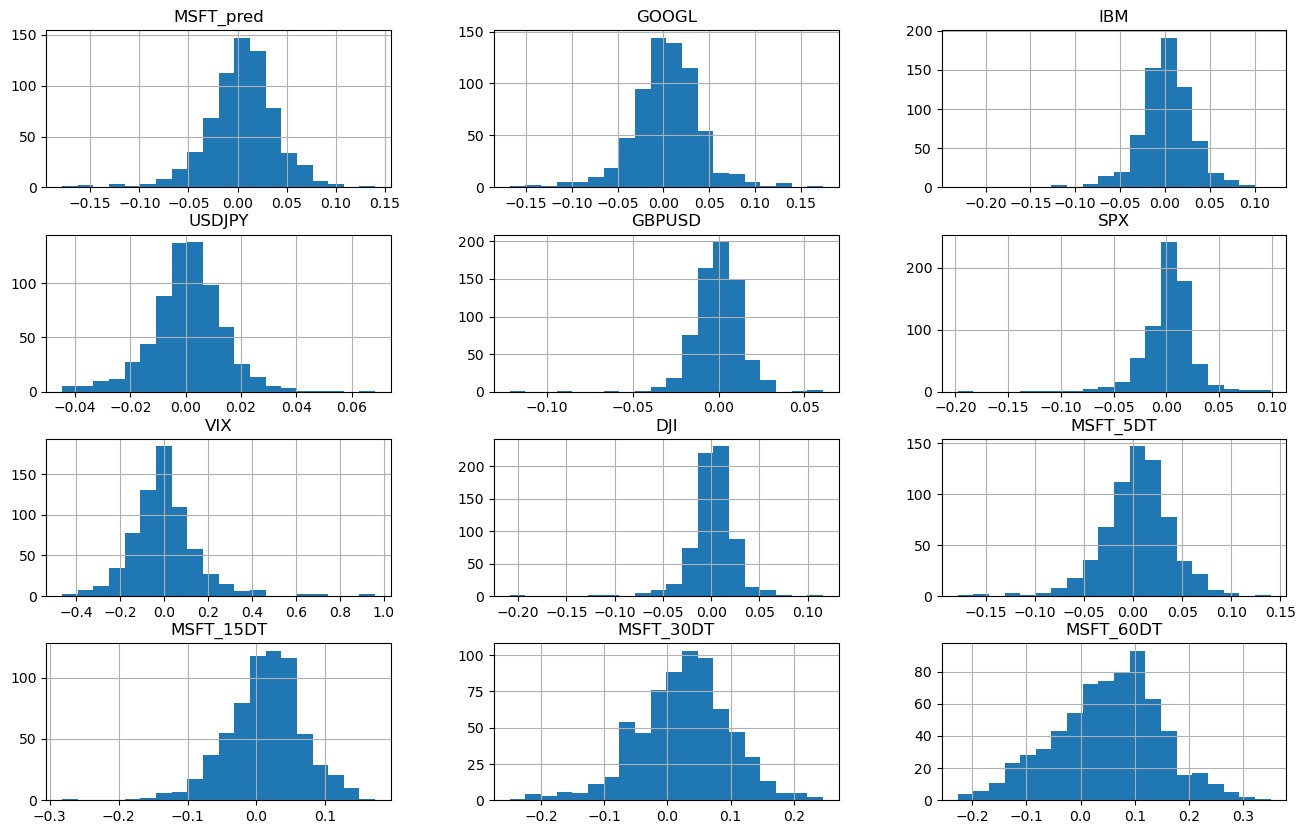

In [10]:
from matplotlib import pyplot
import seaborn as sns
dataset.hist(bins=20, sharex=False, sharey=False, figsize=(16,10))
pyplot.show()

We can see that the vix has a much larger variance compared to the other distributions.

<Axes: title={'center': 'Correlation Matrix'}>

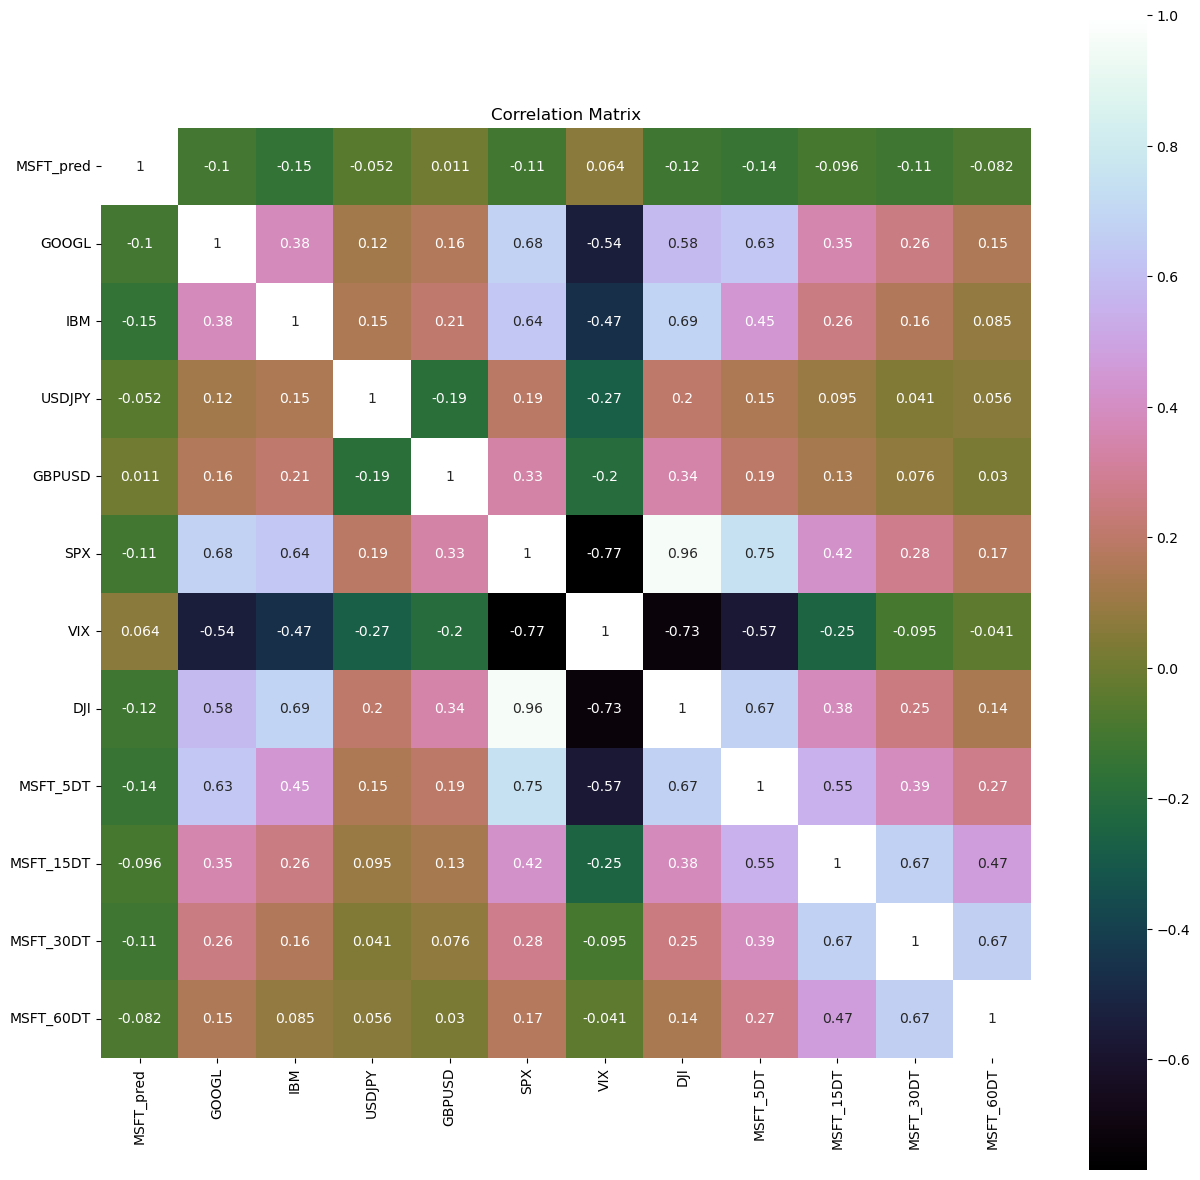

In [11]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

观察相关性图（GitHub 上提供完整尺寸版本），我们可以看到预测变量与微软（MSFT）的滞后5天、15天、30天和60天的回报之间存在一定的相关性。此外，我们还可以看到许多资产回报与VIX之间的较高负相关性，这是很直观的。接下来，我们可以使用下面显示的散点图矩阵来可视化回归中所有变量之间的关系。

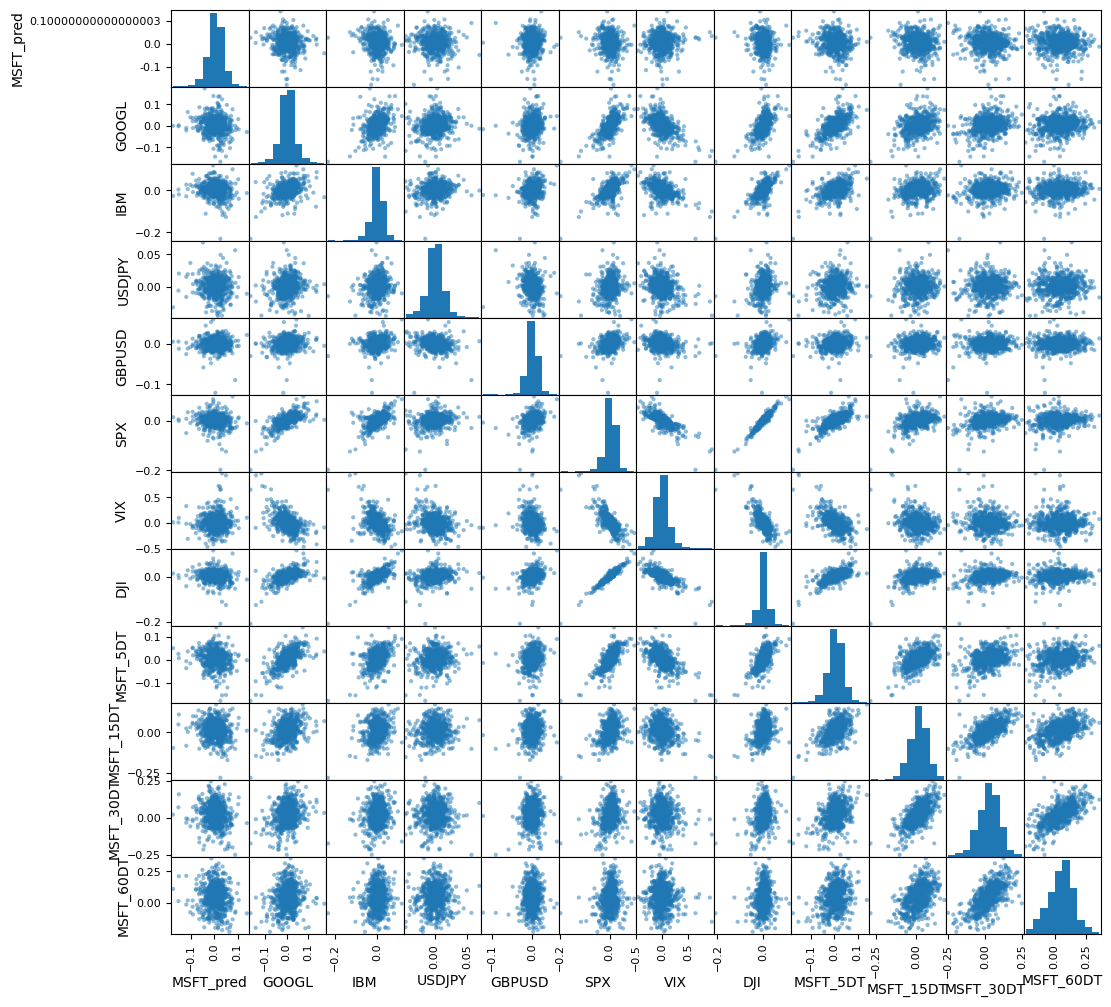

In [12]:
from pandas.plotting import scatter_matrix
#pyplot.figure(figsize=(12,12))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

观察散点图，我们可以看到预测变量与微软（MSFT）的滞后15天、30天和60天的回报之间存在一些线性关系。除此之外，我们并未观察到预测变量与其他特征之间的特殊关系。

<a id='3.3'></a>
### 3.3. 时间序列分析

下一步，我们深入进行时间序列分析，观察将预测变量的时间序列分解为趋势和季节性组成部分：

In [13]:
sm.tsa.seasonal_decompose?

Object `sm.tsa.seasonal_decompose` not found.


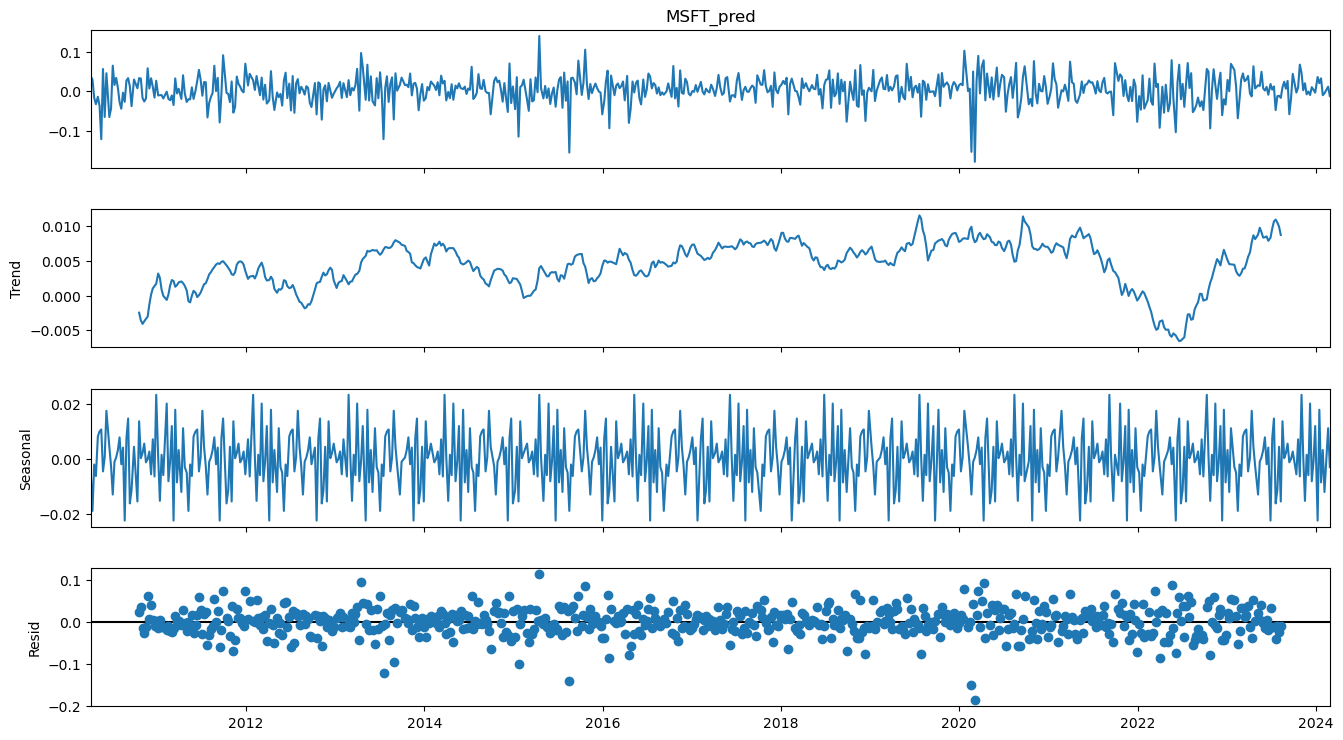

In [14]:
#Libraries for Statistical Models
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

我们可以看到，对于微软（MSFT），回报系列呈现出一般的上升趋势。这可能是由于近年来微软股价大幅上涨，导致正向周回报数据点比负向更多。这种趋势可能在我们模型的常数/偏置项中显示出来。残差（或白噪声）项在整个时间序列中相对较小。


## 4. 评估算法和模型

<a id='5.1'></a>
### 4.1. 训练/测试分割

正如前面章所述，将原始数据集分割为训练集和测试集是一个好主意。测试集是我们从分析和建模中保留的数据样本。我们在项目的最后阶段使用它来确认我们最终模型的性能。这是最终的测试，让我们对未见数据的准确性估计有信心。我们将使用数据集的80%用于建模，使用20%进行测试。对于时间序列数据，数值的顺序很重要。因此，我们不会随机分配数据集到训练集和测试集中，而是选择有序观测值列表中的任意拆分点，并创建两个新数据集：

In [15]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
### 4.2. 评估指标

In [16]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error' 

## 5. 机器学习模型

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error


#### 回归和树回归算法

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

#### 神经网络算法

In [19]:
models.append(('MLP', MLPRegressor()))

#### 集成学习回归

In [20]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

一旦我们选择了所有的模型，我们就会对每一个模型进行循环。

首先，我们运行k折分析。接下来，我们在整个训练和测试数据集上运行模型。

所有的算法都使用默认调整参数。我们将计算每个算法的评估指标的均值和标准差，并收集结果以供后续模型比较使用：

In [21]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001215 (0.000415) 0.001146 0.001294
LASSO: 0.001204 (0.000403) 0.001199 0.001273
EN: 0.001204 (0.000403) 0.001199 0.001273
KNN: 0.001424 (0.000434) 0.000948 0.001166
CART: 0.002766 (0.000621) 0.000000 0.002505
SVR: 0.002097 (0.000575) 0.001817 0.001945
MLP: 0.001273 (0.000388) 0.001175 0.001220
ABR: 0.001244 (0.000389) 0.000865 0.001393
GBR: 0.001429 (0.000423) 0.000403 0.001338
RFR: 0.001326 (0.000417) 0.000182 0.001292
ETR: 0.001320 (0.000429) 0.000000 0.001285


#### K折交叉检验

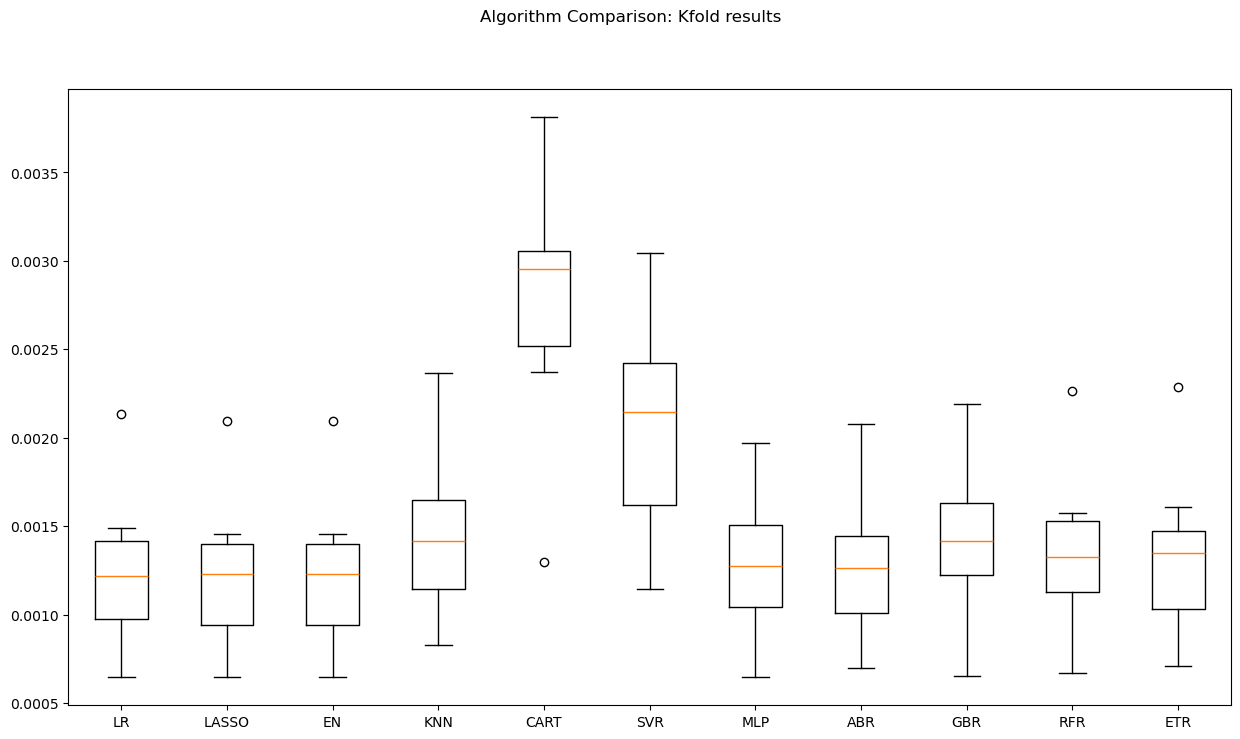

In [22]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

尽管其中几个模型的结果看起来不错，但线性回归以及包括LASSO回归和弹性网（EN）的正则化回归似乎表现最佳。这表明因变量和自变量之间存在着强烈的线性关系。回到探索性分析，我们看到目标变量与不同滞后的MSFT变量之间存在良好的相关性和线性关系。

#### 训练和测试误差

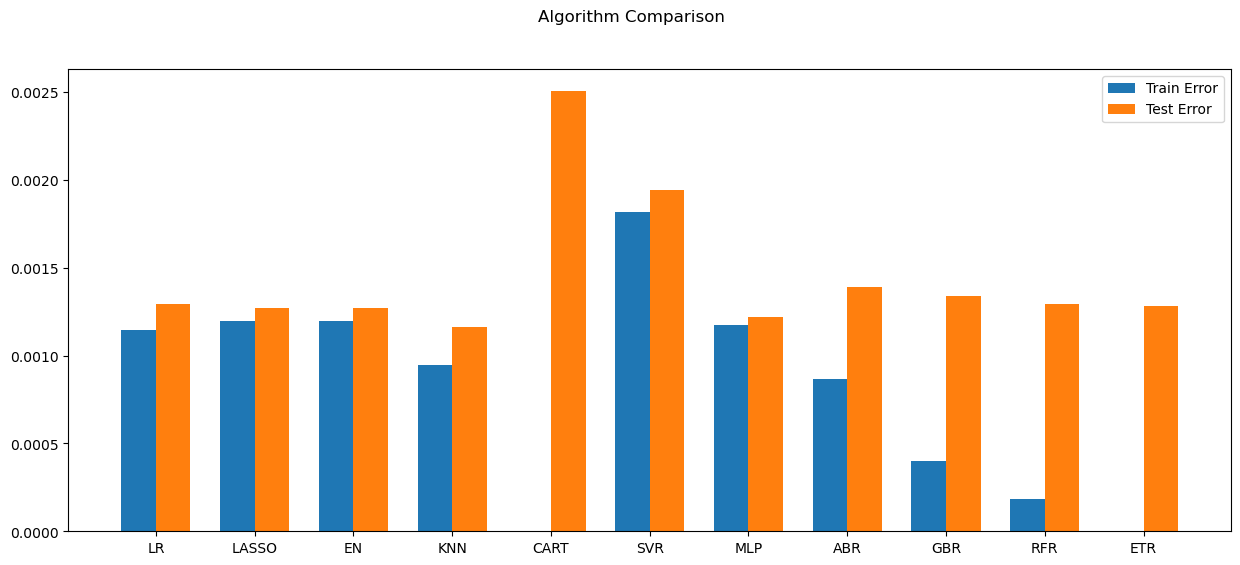

In [23]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,6)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

观察训练和测试误差，我们仍然看到线性模型的性能更好。一些算法，如决策树回归器（CART），在训练数据上过拟合，并在测试集上产生了非常高的误差，应该避免使用这些模型。集成模型，如梯度提升回归（GBR）和随机森林回归（RFR），具有较低的偏差但较高的方差。我们还看到人工神经网络（在图表中显示为MLP）算法在训练集和测试集上的误差较高，这可能是由于变量之间的线性关系未被ANN准确捕捉到，或者超参数不当，或者模型训练不足所致。

我们从交叉验证结果和散点图中最初的直觉似乎也显示了线性模型的更好性能。现在，我们将研究一些可以使用的时间序列和深度学习模型。完成创建后，我们将比较它们的性能与监督回归模型的性能。由于时间序列模型的特性，我们无法进行k-fold分析。但我们仍然可以根据完整的训练和测试结果将我们的结果与其他模型进行比较。

## 总结

我们得出的结论是，简单模型（例如线性回归、正则化回归（即 Lasso 和弹性网络））以及时间序列模型（例如 ARIMA）是资产价格预测问题中很有前途的建模方法。这些模型可以让金融从业人员以非常灵活的方式对时间依赖性进行建模。本案例研究中提出的整体方法可以帮助我们应对过拟合和欠拟合问题，这些都是金融预测问题中的关键挑战。

我们还应该注意，我们可以使用更好的指标集，例如市盈率、交易量、技术指标或新闻数据，这可能会带来更好的结果。我们将在本书中的一些案例研究中对此进行演示。

总而言之，我们创建了一个监督回归和时间序列建模框架，该框架允许我们使用历史数据进行资产类别预测，从而在投入任何实际资本之前生成结果并分析风险和盈利能力。
